In [33]:


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from yahoo_fin import stock_info as si
from collections import deque

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import random


# set seed, so we can get the same results after rerunning several times
np.random.seed(314)
tf.random.set_seed(314)
random.seed(314)



def load_data(ticker, n_steps=50, scale=True, shuffle=True, lookup_step=1, 
                test_size=0.2, feature_columns=['adjclose', 'volume', 'open', 'high', 'low']):
    # see if ticker is already a loaded stock from yahoo finance
    if isinstance(ticker, str):
        # load it from yahoo_fin library
        df = si.get_data(ticker)
    elif isinstance(ticker, pd.DataFrame):
        # already loaded, use it directly
        df = ticker
    # this will contain all the elements we want to return from this function
    result = {}
    # we will also return the original dataframe itself
    result['df'] = df.copy()
    # make sure that the passed feature_columns exist in the dataframe
    for col in feature_columns:
        assert col in df.columns, f"'{col}' does not exist in the dataframe."
    if scale:
        column_scaler = {}
        # scale the data (prices) from 0 to 1
        for column in feature_columns:
            scaler = preprocessing.MinMaxScaler()
            df[column] = scaler.fit_transform(np.expand_dims(df[column].values, axis=1))
            column_scaler[column] = scaler

        # add the MinMaxScaler instances to the result returned
        result["column_scaler"] = column_scaler
    # add the target column (label) by shifting by `lookup_step`
    df['future'] = df['adjclose'].shift(-lookup_step)
    # last `lookup_step` columns contains NaN in future column
    # get them before droping NaNs
    last_sequence = np.array(df[feature_columns].tail(lookup_step))
    # drop NaNs
    df.dropna(inplace=True)
    sequence_data = []
    sequences = deque(maxlen=n_steps)
    for entry, target in zip(df[feature_columns].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == n_steps:
            sequence_data.append([np.array(sequences), target])
    # get the last sequence by appending the last `n_step` sequence with `lookup_step` sequence
    # for instance, if n_steps=50 and lookup_step=10, last_sequence should be of 59 (that is 50+10-1) length
    # this last_sequence will be used to predict in future dates that are not available in the dataset
    last_sequence = list(sequences) + list(last_sequence)
    # shift the last sequence by -1
    last_sequence = np.array(pd.DataFrame(last_sequence).shift(-1).dropna())
    # add to result
    result['last_sequence'] = last_sequence
    # construct the X's and y's
    X, y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        y.append(target)
    # convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    # reshape X to fit the neural network
    X = X.reshape((X.shape[0], X.shape[2], X.shape[1]))
    # split the dataset
    result["X_train"], result["X_test"], result["y_train"], result["y_test"] = train_test_split(X, y, test_size=test_size, shuffle=shuffle)
    # return the result
    return result

def create_model(sequence_length, units=256, cell=LSTM, n_layers=2, dropout=0.3,
                loss="mean_absolute_error", optimizer="rmsprop", bidirectional=False):
    model = Sequential()
    for i in range(n_layers):
        if i == 0:
            # first layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True), input_shape=(None, sequence_length)))
            else:
                model.add(cell(units, return_sequences=True, input_shape=(None, sequence_length)))
        elif i == n_layers - 1:
            # last layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=False)))
            else:
                model.add(cell(units, return_sequences=False))
        else:
            # hidden layers
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True)))
            else:
                model.add(cell(units, return_sequences=True))
        # add dropout after each layer
        model.add(Dropout(dropout))
    model.add(Dense(1, activation="linear"))
    model.compile(loss=loss, metrics=["mean_absolute_error"], optimizer=optimizer)
    return model


# Window size or the sequence length
N_STEPS = 100
# Lookup step, 1 is the next day
LOOKUP_STEP = 1
# test ratio size, 0.2 is 20%
TEST_SIZE = 0.2
# features to use
FEATURE_COLUMNS = ["adjclose", "volume", "open", "high", "low"]
# date now
date_now = time.strftime("%Y-%m-%d")
### model parameters
N_LAYERS = 3
# LSTM cell
CELL = LSTM
# 256 LSTM neurons
UNITS = 256
# 40% dropout
DROPOUT = 0.4
# whether to use bidirectional RNNs
BIDIRECTIONAL = False
### training parameters
# mean absolute error loss
# LOSS = "mae"
# huber loss
LOSS = "huber_loss"
OPTIMIZER = "adam"
BATCH_SIZE = 64
EPOCHS = 10


# save the dataframe
from datetime import date
from datetime import datetime

start_date = date(2019, 6,30)
end_date = date(2020, 6, 30)
days = np.busday_count(start_date, end_date)



# Apple stock market
ticker = "AAPL"
ticker_data_filename = os.path.join("data", f"{ticker}_{date_now}.csv")
# model name to save, making it as unique as possible based on parameters
model_name = f"{date_now}_{ticker}-{LOSS}-{OPTIMIZER}-{CELL.__name__}-seq-{N_STEPS}-step-{LOOKUP_STEP}-layers-{N_LAYERS}-units-{UNITS}"
if BIDIRECTIONAL:
    model_name += "-b"


# create these folders if they does not exist
if not os.path.isdir("results"):
    os.mkdir("results")
if not os.path.isdir("logs"):
    os.mkdir("logs")
if not os.path.isdir("data"):
    os.mkdir("data")
    

# load the data
data = load_data(ticker, N_STEPS, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE, feature_columns=FEATURE_COLUMNS)

# save the dataframe
data["df"].to_csv(ticker_data_filename)

# construct the model
model = create_model(N_STEPS, loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)

# some tensorflow callbacks
checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))

history = model.fit(data["X_train"], data["y_train"],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(data["X_test"], data["y_test"]),
                    callbacks=[checkpointer, tensorboard],
                    verbose=1)

model.save(os.path.join("results", model_name) + ".h5")


# after the model ends running...or during training, run this
# tensorboard --logdir="logs"
# http://localhost:6006/


data = load_data(ticker, N_STEPS, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE,
                feature_columns=FEATURE_COLUMNS, shuffle=False)

# construct the model
model = create_model(N_STEPS, loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)

model_path = os.path.join("results", model_name) + ".h5"
model.load_weights(model_path)


# evaluate the model
mse, mae = model.evaluate(data["X_test"], data["y_test"], verbose=0)
# calculate the mean absolute error (inverse scaling)
mean_absolute_error = data["column_scaler"]["adjclose"].inverse_transform([[mae]])[0][0]
print("Mean Absolute Error:", mean_absolute_error)



Epoch 1/10
124/124 [==============================] - ETA: 0s - loss: 8.1144e-04 - mean_absolute_error: 0.0176
Epoch 00001: val_loss improved from inf to 0.00025, saving model to results\2020-07-20_AAPL-huber_loss-adam-LSTM-seq-100-step-1-layers-3-units-256.h5
124/124 [==============================] - 11s 93ms/step - loss: 8.1144e-04 - mean_absolute_error: 0.0176 - val_loss: 2.5285e-04 - val_mean_absolute_error: 0.0088
Epoch 2/10
124/124 [==============================] - ETA: 0s - loss: 5.7589e-04 - mean_absolute_error: 0.0151- ETA: 4s - loss: 5.0 - ETA: 1s - loss: 5.4300e-04 - mean_absol
Epoch 00002: val_loss did not improve from 0.00025
124/124 [==============================] - 11s 85ms/step - loss: 5.7589e-04 - mean_absolute_error: 0.0151 - val_loss: 2.9680e-04 - val_mean_absolute_error: 0.0116
Epoch 3/10
124/124 [==============================] - ETA: 0s - loss: 4.6900e-04 - mean_absolute_error: 0.0139- ETA: 0s - loss: 4.8242e-04 - mean_absolute
Epoch 00003: val_loss did not imp

In [35]:

def predict(model, data, classification=False):
    # retrieve the last sequence from data
    last_sequence = data["last_sequence"][:N_STEPS]
    # retrieve the column scalers
    column_scaler = data["column_scaler"]
    # reshape the last sequence
    last_sequence = last_sequence.reshape((last_sequence.shape[1], last_sequence.shape[0]))
    # expand dimension
    last_sequence = np.expand_dims(last_sequence, axis=0)
    # get the prediction (scaled from 0 to 1)
    prediction = model.predict(last_sequence)
    # get the price (by inverting the scaling)
    predicted_price = column_scaler["adjclose"].inverse_transform(prediction)[0][0]
    return predicted_price


# predict the future price
future_price = predict(model, data)
print(f"Future price after {LOOKUP_STEP} days is ${future_price:.2f}")


Future price after 1 days is $ 381.02


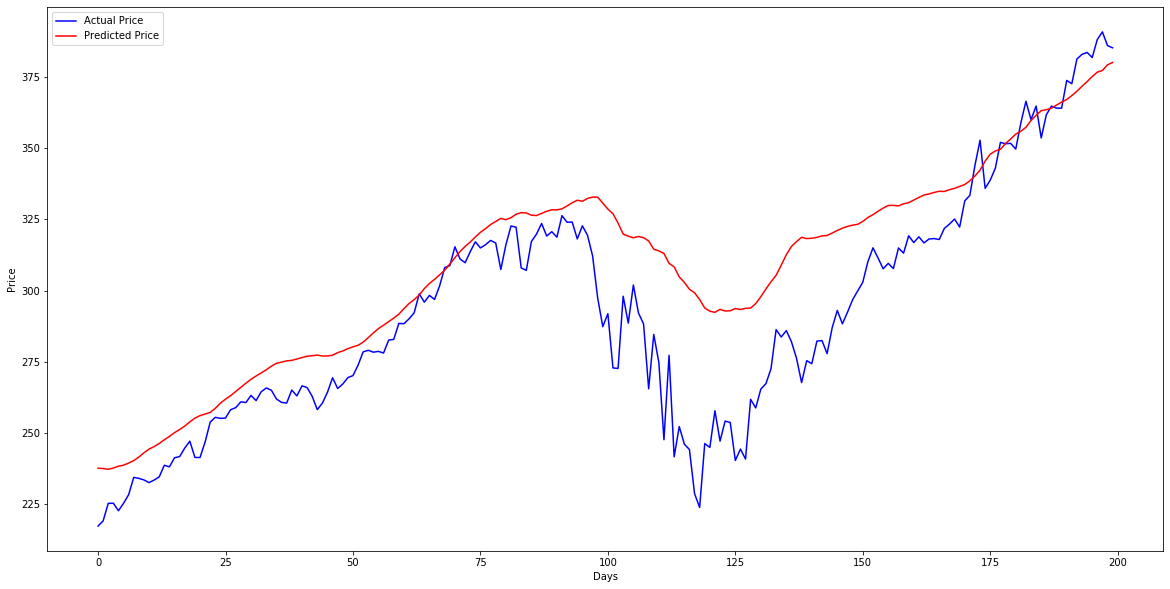

In [30]:

def plot_graph(model, data):
    y_test = data["y_test"]
    X_test = data["X_test"]
    y_pred = model.predict(X_test)
    y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test, axis=0)))
    y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))
    # last 200 days, feel free to edit that
    plt.plot(y_test[-200:], c='b')
    plt.plot(y_pred[-200:], c='r')
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend(["Actual Price", "Predicted Price"])
    plt.show()
    
    
plot_graph(model, data)


In [31]:

def get_accuracy(model, data):
    y_test = data["y_test"]
    X_test = data["X_test"]
    y_pred = model.predict(X_test)
    y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test, axis=0)))
    y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))
    y_pred = list(map(lambda current, future: int(float(future) > float(current)), y_test[:-LOOKUP_STEP], y_pred[LOOKUP_STEP:]))
    y_test = list(map(lambda current, future: int(float(future) > float(current)), y_test[:-LOOKUP_STEP], y_test[LOOKUP_STEP:]))
    return accuracy_score(y_test, y_pred)


print(str(LOOKUP_STEP) + ":", "Accuracy Score:", get_accuracy(model, data))


1: Accuracy Score: 0.5273279352226721


In [ ]:

# In this experiemnt we collected data for AAPL, for one year, from 06/30/1919 to 06/30/2020, and we tried to predict the closing price for 07/01/2020.  The model said the price would be 381.02 and the actual closing price on that day was 364.11.  The model was off by around 5%.  That's is not bad, given that stock prices are nororiously difficult to forecast, especially when compared to things like weather forecasting or sales forecasting, which are much more predictable.  Obviously, investing is not a physical science.  It is based on human psychology, which can be logical, as well as irrational.


In [ ]:

# data:
# All data is imported from Yahoo Finance.  Yahoo sources the data from Capital IQ.